In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

## Load dataset

In [2]:
incident_data = pd.read_csv("incidents.csv")
event_data = pd.read_csv("events.csv")
coordinate_data = pd.read_csv("coordinates.csv")

incident_data.head(20)
event_data.head(20)
coordinate_data.head(20)

,incident_id,lon,lat
0,60854a2aadbe3a63a8cea480,-9.253264,38.756412
1,60854a2aadbe3a63a8cea480,-9.253255,38.756479
2,60854a2aadbe3a63a8cea480,-9.253234,38.756505
3,60854a2aadbe3a63a8cea480,-9.253185,38.756542
4,60854a2aadbe3a63a8cea480,-9.252409,38.756941
5,60854a2aadbe3a63a8cea480,-9.252314,38.756994
6,60854a2aadbe3a63a8cea480,-9.252260,38.757024
7,60854a2aadbe3a63a8cea480,-9.252099,38.757126
8,60854a2aadbe3a63a8cea480,-9.251647,38.757438
9,60854a2aadbe3a63a8cea480,-9.251495,38.757538


## Preprocess dataset

In [3]:
incident_data.isnull().sum()
incident_data.drop(incident_data.columns[[0,1,2,4,6,9,10,11,12]], axis=1, inplace=True) # endtime é 6
incident_data = incident_data.dropna() # Para ter a certeza que não há valores nulos
incident_data.isnull().sum()

properties_iconCategory    0
properties_startTime       0
properties_from            0
properties_to              0
dtype: int64

In [4]:
incident_data.head(20)

,properties_iconCategory,properties_startTime,properties_from,properties_to
0,8,2020-03-30T14:29:30Z,Rua Dom Pedro IV (N117),Rua Elias Garcia (N117)
1,8,2021-04-22T21:07:30Z,Alameda Hermano Patrone (N117) / Rua Major Afo...,Rua Doutor António Granjo
2,6,2021-04-25T10:34:30Z,Avenida Adolfo Casais Monteiro,Praça José Escada
3,6,2021-04-25T10:48:00Z,Brandoa,Rua Luís Pinto Coelho
4,6,2021-04-25T09:42:30Z,Rua da Quinta do Pinheiro,Rua da Quinta do Paizinho
5,6,2021-04-25T09:10:00Z,Rua da Quinta do Paizinho,N117
6,6,2021-04-25T08:51:30Z,exit [5],N117
7,6,2021-04-25T06:51:30Z,Estrada Dos Salgados (Estrada Da Brandoa),Avenida Ruy Luís Gomes (Estrada Da Brandoa)
8,8,2021-04-25T07:00:00Z,Ajuda,Calçada do Galvão
9,8,2021-04-25T07:00:00Z,Calçada do Galvão,Ajuda


## Create training and test data

In [5]:
msk = np.random.rand(len(incident_data)) < 0.8

train_data = incident_data[msk] # 80% of data
test_data = incident_data[~msk] # 20% of data

## Turning non-numerical values into numerical

In [6]:
#ord_enc = OrdinalEncoder()
#for i in ['properties_iconCategory','properties_startTime','properties_from','properties_to']:
#    train_data[i] = ord_enc.fit_transform(train_data[[i]]).astype(int)
#    test_data[i] = ord_enc.fit_transform(test_data[[i]]).astype(int)
    
#train_data.head(20)

from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()

for i in ['properties_iconCategory','properties_startTime','properties_from','properties_to']:
    
    enc.fit(train_data[[i]])
    train_data[[i]] = enc.transform(train_data[[i]])
    
    enc.fit(test_data[[i]])
    test_data[[i]] = enc.transform(test_data[[i]])
    
train_data.head(20)

C:\Users\hugom\anaconda3\envs\ind\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\hugom\anaconda3\envs\ind\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\hugom\anaconda3\envs\ind\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

,properties_iconCategory,properties_startTime,properties_from,properties_to
0,1,1,1566,1519
1,1,45,64,1477
2,0,61,128,1078
3,0,62,611,1714
4,0,58,2387,2108
6,0,56,2825,990
7,0,49,759,476
8,1,50,46,686
9,1,50,658,29
11,1,2,79,690


### Normalizing data

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))

for i in ['properties_iconCategory','properties_startTime','properties_from','properties_to']:
    
    train_data[[i]] = scaler.fit_transform(train_data[[i]])
    test_data[[i]] = scaler.fit_transform(test_data[[i]])
    
train_data.head(20)

C:\Users\hugom\anaconda3\envs\ind\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\hugom\anaconda3\envs\ind\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
C:\Users\hugom\anaconda3\envs\ind\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

,properties_iconCategory,properties_startTime,properties_from,properties_to
0,0.5,0.000126,0.553357,0.618234
1,0.5,0.005691,0.022615,0.601140
2,0.0,0.007715,0.045230,0.438746
3,0.0,0.007841,0.215901,0.697599
4,0.0,0.007335,0.843463,0.857957
6,0.0,0.007082,0.998233,0.402930
7,0.0,0.006197,0.268198,0.193732
8,0.5,0.006324,0.016254,0.279202
9,0.5,0.006324,0.232509,0.011803
11,0.5,0.000253,0.027915,0.280830


In [8]:
def print_series_prediction(y_test,predic):
    plt.plot(y_test,color='blue', label='y_test')
    plt.plot(predic,color='red', label='prediction')
    plt.legend(loc='upper left')
    plt.show()

def knn_classifier(datasets):
    
    (X_train,y_train,X_test,y_test) = datasets
    
    model = KNeighborsClassifier(n_neighbors=3).fit(X_train,y_train)
    predictions = model.predict(X_test)
    df = pd.DataFrame({'actual':y_test,'predicted':predictions})
    print(df)
    print(accuracy_score(df['actual'], df['predicted']))
    print_series_prediction(y_test,df['predicted'])
    


In [9]:
# Treino
def data_startTime():
    c1 = train_data.value_counts('properties_startTime')

    rows = []

    for index, value in c1.items():
    
         rows.append([index, value])

    df = pd.DataFrame(rows, columns=["properties_startTime", "num_incidents"])
    X_train = df.drop(['num_incidents'],axis=1).values
    y_train = df['num_incidents'].values


    # Teste
    c2 = test_data.value_counts('properties_startTime')

    rows2 = []

    for index, value in c2.items():
    
         rows2.append([index, value])

    tmp_time = pd.DataFrame(rows, columns=["properties_startTime", "num_incidents"])
    X_test = tmp_time.drop(['num_incidents'],axis=1).values
    y_test = tmp_time['num_incidents'].values
    
    return (X_train,y_train,X_test,y_test)

In [10]:
def data_iconCategory():
    c1 = train_data.value_counts('properties_iconCategory')

    rows = []

    for index, value in c1.items():
    
         rows.append([index, value])

    df = pd.DataFrame(rows, columns=["properties_iconCategory", "num_incidents"])
    X_train = df.drop(['num_incidents'],axis=1).values
    y_train = df['num_incidents'].values


    # Teste
    c2 = test_data.value_counts('properties_iconCategory')

    rows2 = []

    for index, value in c2.items():
    
         rows2.append([index, value])

    tmp_time = pd.DataFrame(rows, columns=["properties_iconCategory", "num_incidents"])
    X_test = tmp_time.drop(['num_incidents'],axis=1).values
    y_test = tmp_time['num_incidents'].values
    
    return (X_train,y_train,X_test,y_test)

(array([[0. ],
       [0.5],
       [1. ]]), array([14114,   307,    11], dtype=int64), array([[0. ],
       [0.5],
       [1. ]]), array([14114,   307,    11], dtype=int64))
   actual  predicted
0   14114         11
1     307         11
2      11         11
0.3333333333333333


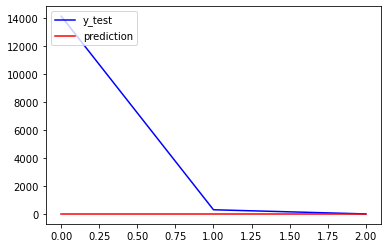

      actual  predicted
0         97          1
1         50         20
2         50         12
3         42          1
4         30          8
...      ...        ...
7903       1          1
7904       1          1
7905       1          1
7906       1          1
7907       1          2

[7908 rows x 2 columns]
0.7405159332321699


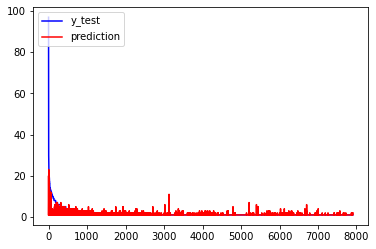

In [11]:
d1 = data_iconCategory()
d2 = data_startTime()
print(d1)
knn_classifier(d1)
knn_classifier(d2)